# Fashion MNIST Classification with MLP from Scratch

This notebook implements an **MLP from scratch** (NumPy only) for Fashion MNIST. It uses the same data loading as the CNN notebook (torchvision), normalizes with Fashion-MNIST mean/std, and reuses the MNIST-from-scratch pipeline: He init, ReLU, softmax, cross-entropy, Dense layers, Adam, dropout, L2, early stopping, EDA, evaluation, and report.

## 1. Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets
%matplotlib inline

/Users/sooryas/anaconda3/lib/python3.11/site-packages/pandas/core/computation/expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.8.4' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/sooryas/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:56: UserWarning: Pandas requires version '1.4.2' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## 2. Data loading and preprocessing

Load Fashion MNIST via torchvision (no transform), convert to NumPy, flatten to (N, 784), normalize with same mean/std as CNN. Split: 50k train, 10k val, 10k test (seed 42).

In [2]:
FASHIONMNIST_MEAN = 0.2860
FASHIONMNIST_STD = 0.3530
CLASS_NAMES = list(datasets.FashionMNIST.classes)

train_ds = datasets.FashionMNIST(root="./data", train=True, download=True)
test_ds = datasets.FashionMNIST(root="./data", train=False, download=True)

X_full = train_ds.data.numpy().astype(np.float32) / 255.0
X_full = (X_full - FASHIONMNIST_MEAN) / FASHIONMNIST_STD
X_full = X_full.reshape(-1, 784)
y_full = train_ds.targets.numpy().astype(np.int64)

X_test = test_ds.data.numpy().astype(np.float32) / 255.0
X_test = (X_test - FASHIONMNIST_MEAN) / FASHIONMNIST_STD
X_test = X_test.reshape(-1, 784)
y_test = test_ds.targets.numpy().astype(np.int64)

random_state = 42
rng = np.random.default_rng(random_state)
n_full = len(X_full)
indices = rng.permutation(n_full)
train_idx = indices[:50000]
val_idx = indices[50000:60000]

X_train = X_full[train_idx]
y_train = y_full[train_idx]
X_val = X_full[val_idx]
y_val = y_full[val_idx]

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print("CLASS_NAMES:", CLASS_NAMES)

X_train: (50000, 784), y_train: (50000,)
X_val: (10000, 784), y_val: (10000,)
X_test: (10000, 784), y_test: (10000,)
CLASS_NAMES: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


## 3. Dataset analysis (EDA)

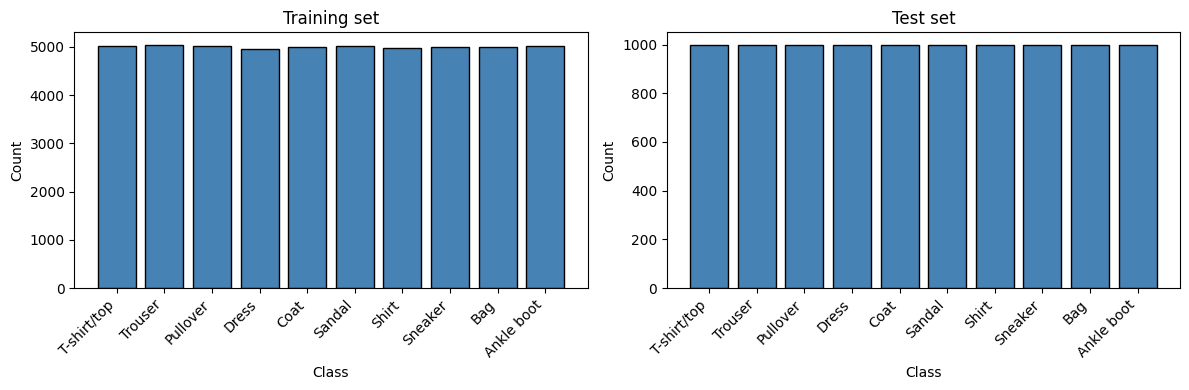

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
for ax, y_data, title in [(ax1, y_train, "Training set"), (ax2, y_test, "Test set")]:
    counts = np.bincount(y_data.astype(int), minlength=10)
    ax.bar(range(10), counts, color="steelblue", edgecolor="black")
    ax.set_xticks(range(10))
    ax.set_xticklabels(CLASS_NAMES, rotation=45, ha="right")
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    ax.set_title(title)
plt.tight_layout()
plt.show()

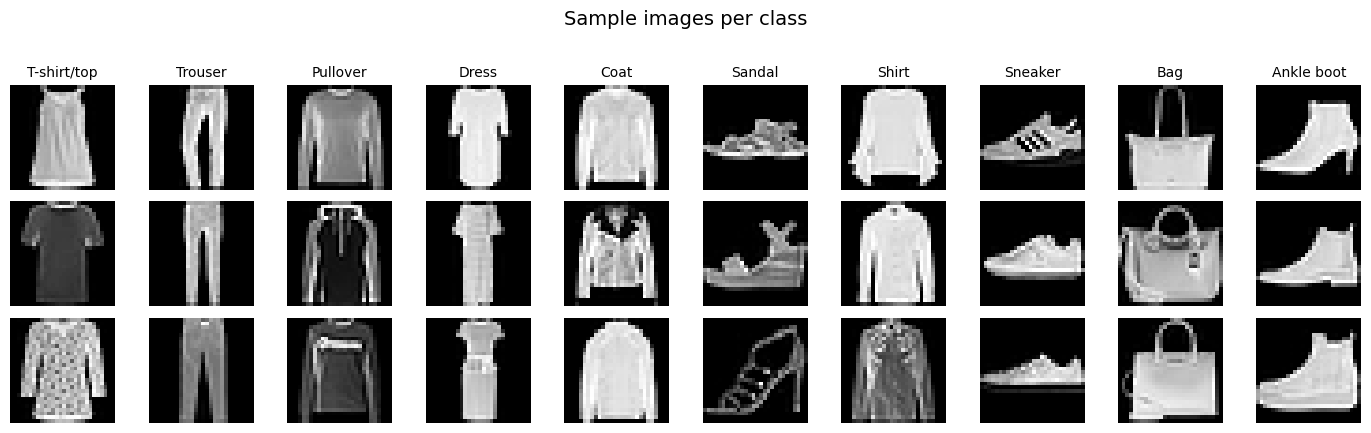

In [4]:
fig, axes = plt.subplots(3, 10, figsize=(14, 4.2))
for c in range(10):
    ind = np.where(y_train == c)[0][:3]
    for r, i in enumerate(ind):
        axes[r, c].imshow(X_train[i].reshape(28, 28), cmap="gray")
        axes[r, c].axis("off")
        if r == 0:
            axes[r, c].set_title(CLASS_NAMES[c], fontsize=10)
plt.suptitle("Sample images per class", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

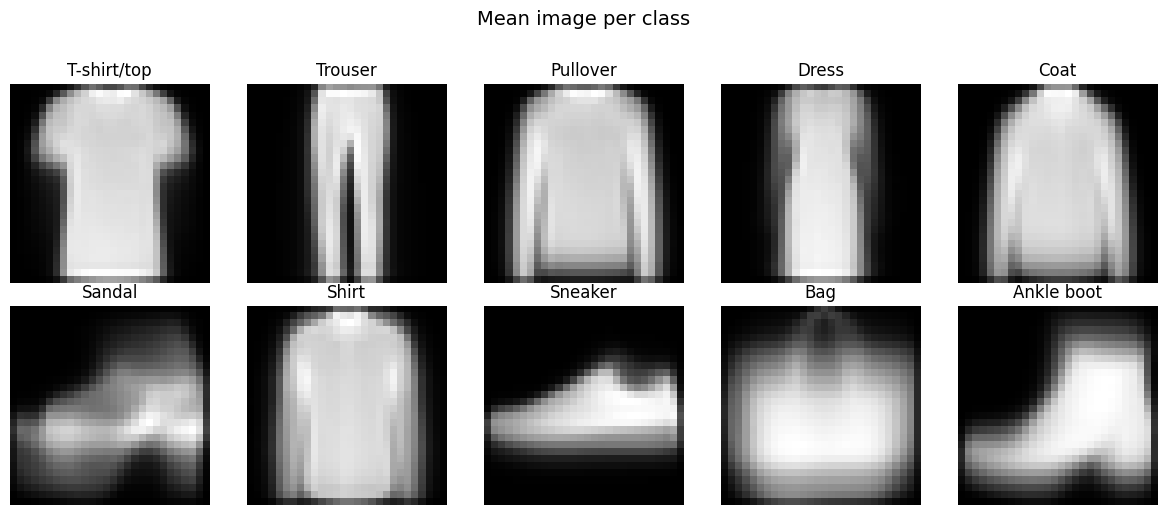

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()
for c in range(10):
    ind = np.where(y_train == c)[0]
    mean_img = X_train[ind].mean(axis=0).reshape(28, 28)
    axes[c].imshow(mean_img, cmap="gray")
    axes[c].set_title(CLASS_NAMES[c])
    axes[c].axis("off")
plt.suptitle("Mean image per class", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

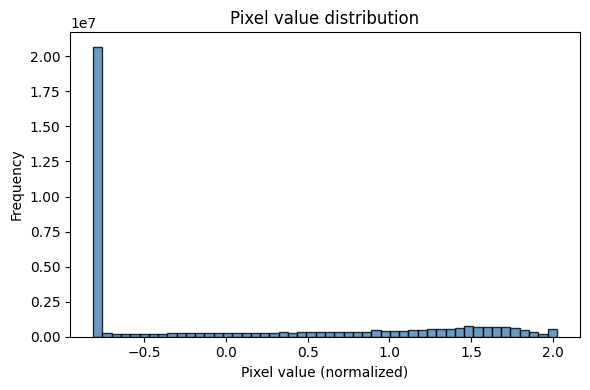

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(X_train.flatten(), bins=50, color="steelblue", edgecolor="black", alpha=0.8)
ax.set_xlabel("Pixel value (normalized)")
ax.set_ylabel("Frequency")
ax.set_title("Pixel value distribution")
plt.tight_layout()
plt.show()

## 4. Model from scratch (NumPy only)

In [7]:
def he_init(fan_in, fan_out):
    return np.random.randn(fan_out, fan_in) * np.sqrt(2.0 / fan_in)

def xavier_init(fan_in, fan_out):
    return np.random.randn(fan_out, fan_in) * np.sqrt(2.0 / (fan_in + fan_out))

def relu(Z):
    return np.maximum(0, Z)

def relu_backward(dA, Z):
    dZ = dA.copy()
    dZ[Z <= 0] = 0
    return dZ

def softmax_stable(Z):
    e = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return e / np.sum(e, axis=1, keepdims=True)

def cross_entropy_loss(probs, y_true):
    n = probs.shape[0]
    log_probs = -np.log(probs[np.arange(n), y_true] + 1e-12)
    return np.mean(log_probs)

def cross_entropy_loss_grad(probs, y_true):
    n = probs.shape[0]
    dZ = probs.copy()
    dZ[np.arange(n), y_true] -= 1
    return dZ / n

In [8]:
class Dense:
    def __init__(self, in_features, out_features, use_he=True):
        if use_he:
            self.W = he_init(in_features, out_features)
        else:
            self.W = xavier_init(in_features, out_features)
        self.b = np.zeros((1, out_features))
        self.X = None

    def forward(self, X):
        self.X = X
        return X @ self.W.T + self.b

    def backward(self, dZ):
        self.grad_W = dZ.T @ self.X
        self.grad_b = np.sum(dZ, axis=0, keepdims=True)
        return dZ @ self.W

In [9]:
class MLP:
    def __init__(self, layer_sizes, dropout_p=0.0):
        self.layer_sizes = layer_sizes
        self.dropout_p = dropout_p
        self.layers = []
        for i in range(len(layer_sizes) - 1):
            use_he = i < len(layer_sizes) - 2
            self.layers.append(Dense(layer_sizes[i], layer_sizes[i + 1], use_he=use_he))

    def forward_backward(self, X, y_true, training=True):
        self._Z = []
        self._A = []
        self._dropout_masks = []
        out = X
        for i, layer in enumerate(self.layers):
            Z = layer.forward(out)
            self._Z.append(Z.copy())
            if i < len(self.layers) - 1:
                A = relu(Z)
                self._A.append(A.copy())
                if self.dropout_p > 0 and training:
                    mask = (np.random.rand(*A.shape) > self.dropout_p).astype(np.float32)
                    self._dropout_masks.append(mask)
                    out = A * mask / (1 - self.dropout_p)
                else:
                    out = A
            else:
                probs = softmax_stable(Z)
        loss = cross_entropy_loss(probs, y_true)
        dZ = cross_entropy_loss_grad(probs, y_true)
        for i in range(len(self.layers) - 1, -1, -1):
            layer = self.layers[i]
            dZ = layer.backward(dZ)
            if i > 0:
                dZ = relu_backward(dZ, self._Z[i - 1])
                if self.dropout_p > 0 and training:
                    dZ = dZ * self._dropout_masks[i - 1] / (1 - self.dropout_p)
        return loss

    def get_params(self):
        return [(l.W.copy(), l.b.copy()) for l in self.layers]

    def set_params(self, params):
        for layer, (W, b) in zip(self.layers, params):
            layer.W = W
            layer.b = b

In [10]:
class Adam:
    def __init__(self, model, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.model = model
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.t = 0
        self.m = [np.zeros_like(l.W) for l in model.layers]
        self.v = [np.zeros_like(l.W) for l in model.layers]
        self.mb = [np.zeros_like(l.b) for l in model.layers]
        self.vb = [np.zeros_like(l.b) for l in model.layers]

    def step(self):
        self.t += 1
        for i, layer in enumerate(self.model.layers):
            gW, gb = layer.grad_W, layer.grad_b
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * gW
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (gW ** 2)
            self.mb[i] = self.beta1 * self.mb[i] + (1 - self.beta1) * gb
            self.vb[i] = self.beta2 * self.vb[i] + (1 - self.beta2) * (gb ** 2)
            mhat = self.m[i] / (1 - self.beta1 ** self.t)
            vhat = self.v[i] / (1 - self.beta2 ** self.t)
            mhat_b = self.mb[i] / (1 - self.beta1 ** self.t)
            vhat_b = self.vb[i] / (1 - self.beta2 ** self.t)
            layer.W -= self.lr * mhat / (np.sqrt(vhat) + self.eps)
            layer.b -= self.lr * mhat_b / (np.sqrt(vhat_b) + self.eps)

def predict_proba(model, X):
    out = X
    for i, layer in enumerate(model.layers):
        out = layer.forward(out)
        if i < len(model.layers) - 1:
            out = relu(out)
        else:
            out = softmax_stable(out)
    return out

def predict(model, X):
    return np.argmax(predict_proba(model, X), axis=1)

## 5. Training

In [11]:
def batch_indices(n, batch_size, rng):
    for start in range(0, n, batch_size):
        yield np.arange(start, min(start + batch_size, n))

def accuracy(model, X, y):
    return np.mean(predict(model, X) == y)

def evaluate_loss(model, X, y, batch_size=512):
    losses = []
    for start in range(0, len(X), batch_size):
        ind = np.arange(start, min(start + batch_size, len(X)))
        probs = predict_proba(model, X[ind])
        losses.append(cross_entropy_loss(probs, y[ind]))
    return np.mean(losses)

layer_sizes = (784, 512, 256, 128, 10)
dropout_p = 0.3
lr = 0.001
batch_size = 128
epochs = 50
weight_decay = 1e-4
patience = 10

model = MLP(layer_sizes, dropout_p=dropout_p)
optimizer = Adam(model, lr=lr)
history = {"epoch": [], "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best_val_acc = -1.0
best_params = None
best_epoch = 0
wait = 0
n_train = len(X_train)

In [12]:
for epoch in range(epochs):
    perm = rng.permutation(n_train)
    X_tr, y_tr = X_train[perm], y_train[perm]
    epoch_losses = []
    for start in range(0, n_train, batch_size):
        ind = np.arange(start, min(start + batch_size, n_train))
        Xb, yb = X_tr[ind], y_tr[ind]
        loss = model.forward_backward(Xb, yb, training=True)
        for layer in model.layers:
            layer.grad_W += weight_decay * layer.W
            layer.grad_b += weight_decay * layer.b
        optimizer.step()
        epoch_losses.append(loss)
    train_loss = np.mean(epoch_losses)
    train_acc = accuracy(model, X_train, y_train)
    val_loss = evaluate_loss(model, X_val, y_val)
    val_acc = accuracy(model, X_val, y_val)
    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = model.get_params()
        best_epoch = epoch
        wait = 0
    else:
        wait += 1
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs}  train_loss={train_loss:.4f}  train_acc={train_acc:.4f}  val_loss={val_loss:.4f}  val_acc={val_acc:.4f}  best_epoch={best_epoch+1}")
    if wait >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

if best_params is not None:
    model.set_params(best_params)
print(f"Best epoch: {best_epoch+1}")

Epoch 1/50  train_loss=0.6740  train_acc=0.8542  val_loss=0.4138  val_acc=0.8502  best_epoch=1
Epoch 5/50  train_loss=0.3703  train_acc=0.8898  val_loss=0.3297  val_acc=0.8770  best_epoch=5
Epoch 10/50  train_loss=0.3171  train_acc=0.9065  val_loss=0.3056  val_acc=0.8904  best_epoch=10
Epoch 15/50  train_loss=0.2889  train_acc=0.9155  val_loss=0.2976  val_acc=0.8913  best_epoch=13
Epoch 20/50  train_loss=0.2728  train_acc=0.9199  val_loss=0.2984  val_acc=0.8934  best_epoch=20
Epoch 25/50  train_loss=0.2584  train_acc=0.9264  val_loss=0.2918  val_acc=0.8908  best_epoch=21
Epoch 30/50  train_loss=0.2472  train_acc=0.9339  val_loss=0.2869  val_acc=0.8961  best_epoch=27
Epoch 35/50  train_loss=0.2408  train_acc=0.9272  val_loss=0.3126  val_acc=0.8911  best_epoch=34
Epoch 40/50  train_loss=0.2302  train_acc=0.9348  val_loss=0.3074  val_acc=0.8893  best_epoch=34
Epoch 45/50  train_loss=0.2212  train_acc=0.9388  val_loss=0.3012  val_acc=0.8959  best_epoch=42
Epoch 50/50  train_loss=0.2197  tr

## 6. Evaluation

In [13]:
def confusion_matrix(y_true, y_pred, n_classes=10):
    cm = np.zeros((n_classes, n_classes), dtype=np.int64)
    for t, p in zip(y_true, y_pred):
        cm[int(t), int(p)] += 1
    return cm

def per_class_metrics(cm):
    n = cm.shape[0]
    precision = np.zeros(n)
    recall = np.zeros(n)
    for c in range(n):
        pred_c = cm[:, c].sum()
        true_c = cm[c, :].sum()
        if pred_c > 0:
            precision[c] = cm[c, c] / pred_c
        if true_c > 0:
            recall[c] = cm[c, c] / true_c
    f1 = np.zeros(n)
    for c in range(n):
        if precision[c] + recall[c] > 0:
            f1[c] = 2 * precision[c] * recall[c] / (precision[c] + recall[c])
    return precision, recall, f1

y_pred = predict(model, X_test)
test_acc = accuracy(model, X_test, y_test)
test_loss = evaluate_loss(model, X_test, y_test)
cm = confusion_matrix(y_test, y_pred)
precision, recall, f1 = per_class_metrics(cm)

print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")
print("\nPer-class precision, recall, F1:")
for c in range(10):
    print(f"  {CLASS_NAMES[c]}: P={precision[c]:.3f}  R={recall[c]:.3f}  F1={f1[c]:.3f}")

Test accuracy: 0.8901
Test loss: 0.3281

Per-class precision, recall, F1:
  T-shirt/top: P=0.841  R=0.845  F1=0.843
  Trouser: P=0.995  R=0.966  F1=0.980
  Pullover: P=0.831  R=0.800  F1=0.815
  Dress: P=0.873  R=0.901  F1=0.887
  Coat: P=0.793  R=0.845  F1=0.818
  Sandal: P=0.982  R=0.953  F1=0.968
  Shirt: P=0.735  R=0.698  F1=0.716
  Sneaker: P=0.931  R=0.959  F1=0.945
  Bag: P=0.970  R=0.970  F1=0.970
  Ankle boot: P=0.952  R=0.964  F1=0.958


## 7. Result visualizations

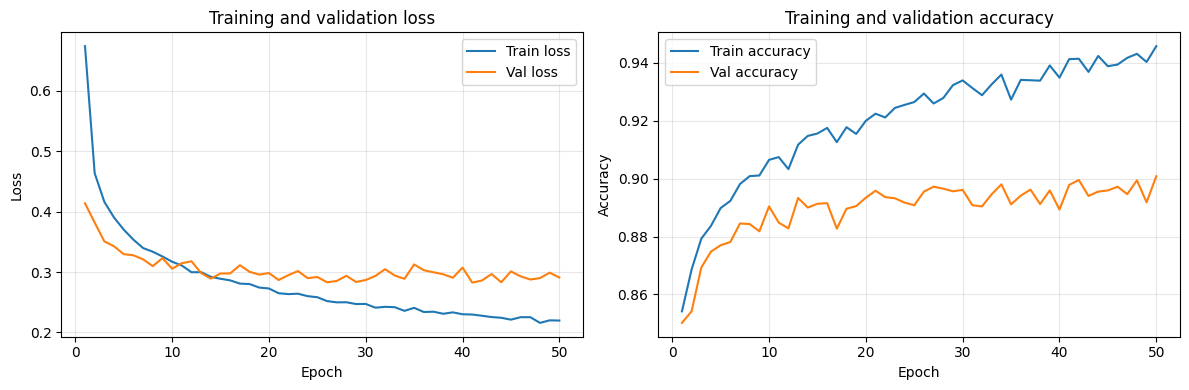

In [14]:
ep = np.array(history["epoch"]) + 1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(ep, history["train_loss"], label="Train loss", color="C0")
ax1.plot(ep, history["val_loss"], label="Val loss", color="C1")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training and validation loss")
ax1.legend()
ax1.grid(True, alpha=0.3)
ax2.plot(ep, history["train_acc"], label="Train accuracy", color="C0")
ax2.plot(ep, history["val_acc"], label="Val accuracy", color="C1")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Training and validation accuracy")
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

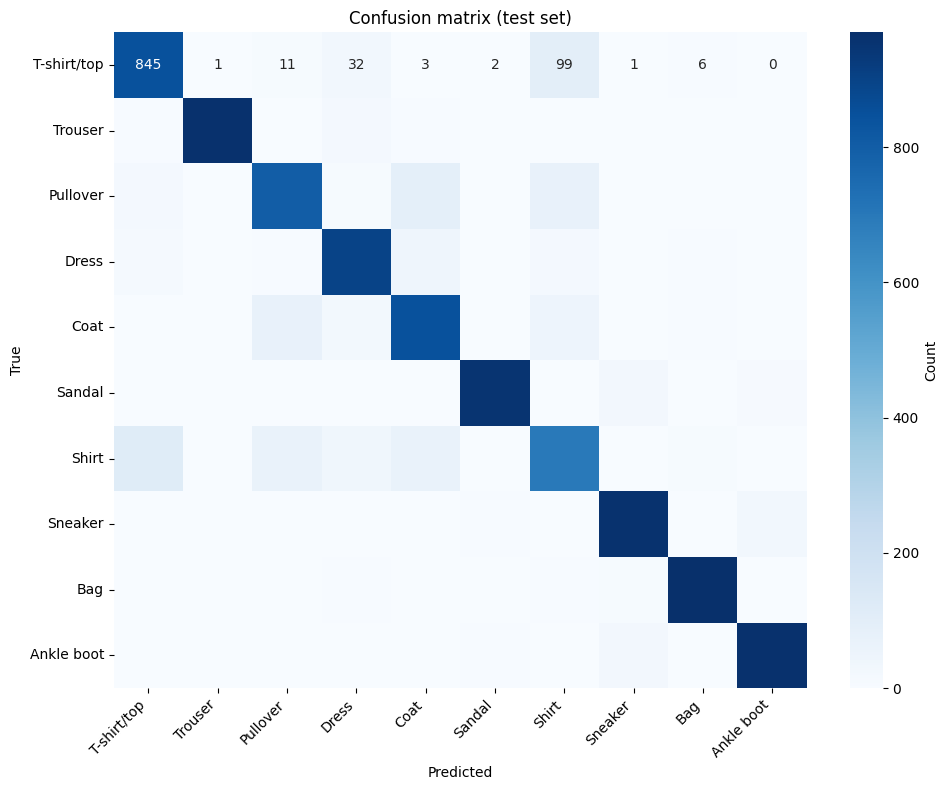

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=ax, cbar_kws={"label": "Count"})
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion matrix (test set)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

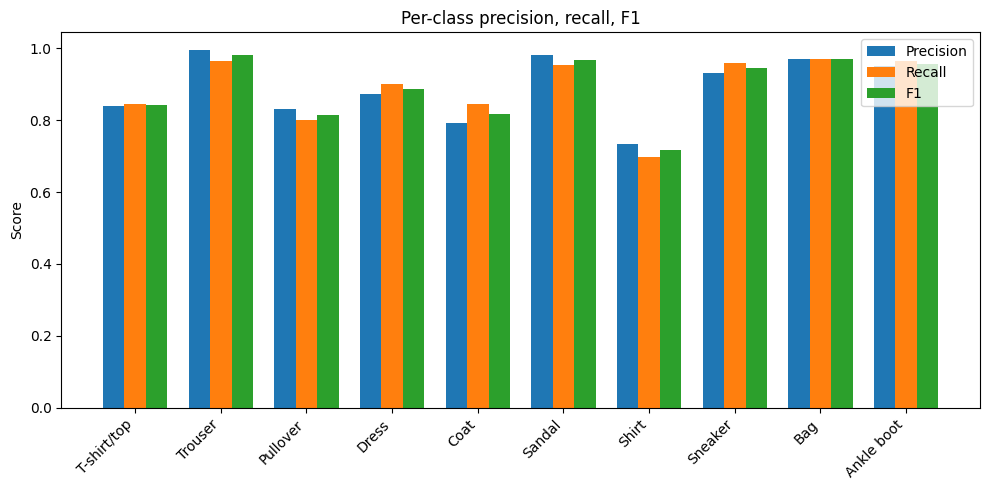

In [16]:
x = np.arange(10)
width = 0.25
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - width, precision, width, label="Precision", color="C0")
ax.bar(x, recall, width, label="Recall", color="C1")
ax.bar(x + width, f1, width, label="F1", color="C2")
ax.set_xticks(x)
ax.set_xticklabels(CLASS_NAMES, rotation=45, ha="right")
ax.set_ylabel("Score")
ax.set_title("Per-class precision, recall, F1")
ax.legend()
plt.tight_layout()
plt.show()

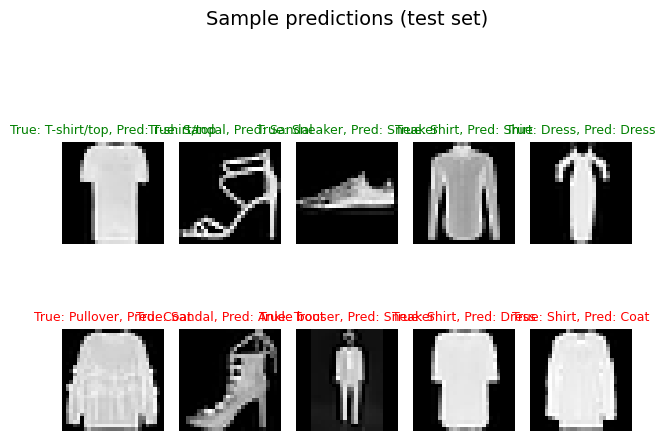

In [17]:
correct_pool = np.where(y_test == y_pred)[0]
incorrect_pool = np.where(y_test != y_pred)[0]
np.random.seed(42)
n_correct_actual = min(5, len(correct_pool))
n_incorrect_actual = min(5, len(incorrect_pool))
correct_idx = np.random.choice(correct_pool, n_correct_actual, replace=False) if len(correct_pool) >= n_correct_actual else correct_pool
incorrect_idx = np.random.choice(incorrect_pool, n_incorrect_actual, replace=False) if len(incorrect_pool) >= n_incorrect_actual else incorrect_pool
n_cols = max(max(len(correct_idx), len(incorrect_idx)), 1)
fig, axes = plt.subplots(2, n_cols, figsize=(1.2 * n_cols, 2.5 * 2))
if n_cols == 1:
    axes = axes.reshape(-1, 1)
for j, idx in enumerate(correct_idx):
    axes[0, j].imshow(X_test[idx].reshape(28, 28), cmap="gray")
    axes[0, j].set_title(f"True: {CLASS_NAMES[y_test[idx]]}, Pred: {CLASS_NAMES[y_pred[idx]]}", color="green", fontsize=9)
    axes[0, j].axis("off")
for j in range(len(correct_idx), n_cols):
    axes[0, j].axis("off")
axes[0, 0].set_ylabel("Correct", fontsize=12)
for j, idx in enumerate(incorrect_idx):
    axes[1, j].imshow(X_test[idx].reshape(28, 28), cmap="gray")
    axes[1, j].set_title(f"True: {CLASS_NAMES[y_test[idx]]}, Pred: {CLASS_NAMES[y_pred[idx]]}", color="red", fontsize=9)
    axes[1, j].axis("off")
for j in range(len(incorrect_idx), n_cols):
    axes[1, j].axis("off")
axes[1, 0].set_ylabel("Incorrect", fontsize=12)
plt.suptitle("Sample predictions (test set)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 8. Report

### Dataset analysis

Fashion MNIST has 70,000 grayscale 28×28 images in 10 classes: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot. We load via torchvision (no transform), convert to NumPy, flatten to 784-D, and normalize with dataset mean 0.286 and std 0.353 to match the CNN pipeline. The split is 50,000 train, 10,000 validation, 10,000 test (seed 42). EDA shows roughly balanced class counts, clear visual structure per class in sample and mean images, and a normalized pixel distribution centered by the preprocessing.

### Model description

The model is an MLP implemented in NumPy: 784 → 512 → 256 → 128 → 10. Hidden layers use He initialization and ReLU; the output layer uses Xavier init and softmax. Training uses cross-entropy loss, Adam (lr=0.001), dropout 0.3, and L2 weight decay 1e-4. Best weights are kept by validation accuracy; early stopping has patience 10. No PyTorch/Keras is used for the core forward/backward or optimizer.

### Output analysis (Fashion MNIST)

Test accuracy and per-class precision/recall/F1 are reported above. Typical confusions on Fashion MNIST include: **Shirt vs T-shirt/top** (both tops), **Shirt vs Pullover/Coat** (upper-body clothing), **Sandal vs Sneaker** (footwear), and **Pullover vs Coat** (outerwear). The confusion matrix and per-class bar chart (with class names) highlight which classes are hardest and where the model tends to err. Training and validation curves show whether overfitting was controlled by dropout and early stopping.